In [140]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import re

In [243]:
path = "Data.csv"
data = pd.read_csv(path)

In [244]:
# Apartments will be 1, Houses 0.
data['Type'] = data['Type'].apply(lambda x: 1 if x == 'Apartment' else 0)


# Cleaning 'Price' column
def clean_price(price):
    price = re.sub(r'[^0-9]', '', price.split('€')[0])  # Extract numeric part before '€'.
    return int(price) if price else None

data['Price'] = data['Price'].apply(clean_price)
data['Price'] = data['Price'].astype(int)

# Missing 'Rooms' to mean value.
data['Amount of Rooms'] = data['Amount of Rooms'].fillna(data['Amount of Rooms'].mean())

# Cleaning 'Surface Area' column.
data['Surface Area'] = data['Surface Area'].str.replace(' m²', '').astype(float)
data['Surface Area'] = data['Surface Area'].fillna(data['Surface Area'].mean())

# Splitting up 'Floor' and 'Total Floors'.
data['Floor'] = data['Floor/Floors'].str.split('/').str[0].astype(float)
data['Total Floors'] = data['Floor/Floors'].str.split('/').str[1].astype(float)
data['Floor'] = data['Floor'].fillna(data['Floor'].mean())
data['Total Floors'] = data['Total Floors'].fillna(data['Total Floors'].mean())

# Drop 'Floor/Floors' column
data = data.drop(columns=['Floor/Floors'])

# Missing 'Town' values -> "Unknown".
data['Town'] = data['Town'].fillna('Unknown')

# Encode 'Sale/Rent' as binary: 0 = For Rent, 1 = For Sale.
data['Sale/Rent'] = data['Sale/Rent'].apply(lambda x: 1 if x == 'For Sale' else 0)

# Using One-Hot Encoding a new Column for each town is created.
data = pd.get_dummies(data, columns=['Town'], drop_first=True)

# Separate the data based on Sale/Rent
sale_data = data[data['Sale/Rent'] == 1]
rent_data = data[data['Sale/Rent'] == 0]

# Drop the 'Sale/Rent' column since it's constant in these subsets.
sale_data = sale_data.drop(columns=['Sale/Rent'])
rent_data = rent_data.drop(columns=['Sale/Rent'])

# Apply price constraints.
sale_data = sale_data[sale_data['Price'] > 2000]
rent_data = rent_data[rent_data['Price'] > 100]
# Separate the features (X) and target (y) for both sale_data and rent_data
X_sale = sale_data.drop(columns=['Price'])
y_sale = sale_data['Price']

X_rent = rent_data.drop(columns=['Price'])
y_rent = rent_data['Price']

# Splitting the data into train and test sets
X_train_sale, X_test_sale, y_train_sale, y_test_sale = train_test_split(X_sale, y_sale, test_size=0.2, random_state=42)
X_train_rent, X_test_rent, y_train_rent, y_test_rent = train_test_split(X_rent, y_rent, test_size=0.2, random_state=42)

In [150]:
# Define the model
rf = RandomForestRegressor()

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 201, 50),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40],      # Depth of the tree
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],            # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider at every split
    'bootstrap': [True, False]                # Whether bootstrap samples are used when building trees
}

# Define the RandomizedSearchCV with 5-fold cross-validation
random_search_sale = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                       n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

random_search_rent = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                       n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV to the training data for sale and rent separately
random_search_sale.fit(X_train_sale, y_train_sale)
random_search_rent.fit(X_train_rent, y_train_rent)

# Get the best parameters from the RandomizedSearchCV
best_params_sale = random_search_sale.best_params_
best_params_rent = random_search_rent.best_params_

print("Best Hyperparameters for Sale Data:", best_params_sale)
print("Best Hyperparameters for Rent Data:", best_params_rent)

# Predict on the test set for both sale and rent data
y_pred_sale = random_search_sale.predict(X_test_sale)
y_pred_rent = random_search_rent.predict(X_test_rent)

# Evaluate the model for sale data
mae_sale = mean_absolute_error(y_test_sale, y_pred_sale)
r2_sale = r2_score(y_test_sale, y_pred_sale)

# Evaluate the model for rent data
mae_rent = mean_absolute_error(y_test_rent, y_pred_rent)
r2_rent = r2_score(y_test_rent, y_pred_rent)

print("Mean Absolute Error for Sale Data:", mae_sale)
print("R-squared for Sale Data:", r2_sale)

print("Mean Absolute Error for Rent Data:", mae_rent)
print("R-squared for Rent Data:", r2_rent)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
79 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
79 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Best Hyperparameters for Sale Data: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
Best Hyperparameters for Rent Data: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Mean Absolute Error for Sale Data: 59422.621928931374
R-squared for Sale Data: 0.6424669524410562
Mean Absolute Error for Rent Data: 259.1190630730236
R-squared for Rent Data: -0.8794827039903261


In [245]:
# Best hyperparameters for Sale data
sale_params = {
    'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 40,
    'bootstrap': True
}

# Best hyperparameters for Rent data
rent_params = {
    'n_estimators': 100,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 10,
    'bootstrap': True
}

# Instantiate the RandomForestRegressor for Sale data
sale_model = RandomForestRegressor(**sale_params)

# Instantiate the RandomForestRegressor for Rent data
rent_model = RandomForestRegressor(**rent_params)

# Fit the models to the respective datasets (X_sale, y_sale, X_rent, y_rent)
# Assuming you have your data in variables X_sale, y_sale for Sale data
# and X_rent, y_rent for Rent data
sale_model.fit(X_sale, y_sale)
rent_model.fit(X_rent, y_rent)

# Evaluate the models
from sklearn.metrics import mean_absolute_error, r2_score

# Predictions for Sale data
y_sale_pred = sale_model.predict(X_sale)
sale_mae = mean_absolute_error(y_sale, y_sale_pred)
sale_r2 = r2_score(y_sale, y_sale_pred)

# Predictions for Rent data
y_rent_pred = rent_model.predict(X_rent)
rent_mae = mean_absolute_error(y_rent, y_rent_pred)
rent_r2 = r2_score(y_rent, y_rent_pred)

print(f"Mean Absolute Error for Sale Data: {sale_mae}")
print(f"R-squared for Sale Data: {sale_r2}")
print(f"Mean Absolute Error for Rent Data: {rent_mae}")
print(f"R-squared for Rent Data: {rent_r2}")

print(sale_data.head())

new_apartment = pd.DataFrame({
    'Amount of Rooms': [3],
    'Surface Area': [67.3],
    'Type': [1],
    'Floor': [1],
    'Total Floors': [4],
    'Town_Narva': [0],
    'Town_Paide': [0],
    'Town_Pärnu': [0],
    'Town_Põlva': [0],
    'Town_Rakvere': [0],
    'Town_Tallinn': [1],
    'Town_Tapa': [0],
    'Town_Tartu': [0],
    'Town_Türi': [0],
    'Town_Unknown': [0],
    'Town_Viljandi': [0],
    'Town_Võru': [0],
})

salePredict = sale_model.predict(new_apartment)
print(salePredict)

Mean Absolute Error for Sale Data: 44663.87947581952
R-squared for Sale Data: 0.7877542902955457
Mean Absolute Error for Rent Data: 334.12647951650956
R-squared for Rent Data: 0.32143530237271367
    Price  Amount of Rooms  Surface Area  Type  Floor  Total Floors  \
0  469900              3.0          86.8     1    2.0           3.0   
1  489900              4.0         103.0     1    2.0           3.0   
2  529900              3.0          85.7     1    3.0           7.0   
3  289900              2.0          53.4     1    3.0           7.0   
4  279000              3.0          64.0     1    2.0          13.0   

   Town_Narva  Town_Paide  Town_Pärnu  Town_Põlva  Town_Rakvere  Town_Tallinn  \
0       False       False       False       False         False          True   
1       False       False       False       False         False          True   
2       False       False       False       False         False          True   
3       False       False       False       False    

In [251]:
import tkinter as tk
from tkinter import messagebox

def predict_sale_price():
    try:
        # Gather user input
        rooms = int(rooms_var.get())
        area = float(area_var.get())
        listing_type = int(type_var.get())
        floor = int(floor_var.get())
        total_floors = int(total_floors_var.get())
        town = town_var.get()
        asking_price = float(asking_price_var.get())

        # Prepare the input for the model
        towns = [
            'Narva', 'Paide', 'Pärnu', 'Põlva', 'Rakvere', 'Tallinn',
            'Tapa', 'Tartu', 'Türi', 'Viljandi', 'Võru', 'Unknown'
        ]
        town_columns = {f'Town_{t}': 0 for t in towns}
        if f'Town_{town}' in town_columns:
            town_columns[f'Town_{town}'] = 1

        input_data = pd.DataFrame([{
            'Amount of Rooms': rooms,
            'Surface Area': area,
            'Type': listing_type,
            'Floor': floor,
            'Total Floors': total_floors,
            **town_columns,
        }])

        # Predict using the sale model
        predicted_price = sale_model.predict(input_data)[0]

        # Calculate the rating
        percentile_diff = abs(asking_price - predicted_price) / predicted_price * 100
        if percentile_diff <= 10:
            rating = 5
        elif percentile_diff <= 20:
            rating = 4
        elif percentile_diff <= 30:
            rating = 3
        elif percentile_diff <= 40:
            rating = 2
        else:
            rating = 1

        # Update result display
        result_label.config(
            text=f"Predicted Price: €{predicted_price:,.2f}\n"
                 f"Rating: {rating}/5\n"
                 f"Percentile Difference: {percentile_diff:.2f}%"
        )
    except Exception as e:
        messagebox.showerror("Error", str(e))


# GUI Setup
root = tk.Tk()
root.title("Real Estate Sale Price Predictor")

# Input Fields
type_var = tk.StringVar(value="1")
rooms_var = tk.StringVar(value="3")
area_var = tk.StringVar(value="70")
floor_var = tk.StringVar(value="2")
total_floors_var = tk.StringVar(value="5")
town_var = tk.StringVar(value="Tallinn")
asking_price_var = tk.StringVar(value="75000")

tk.Label(root, text="Type (1=Apartment, 2=House):").grid(row=0, column=0, sticky="w")
tk.Entry(root, textvariable=type_var).grid(row=0, column=1)

tk.Label(root, text="Amount of Rooms:").grid(row=1, column=0, sticky="w")
tk.Entry(root, textvariable=rooms_var).grid(row=1, column=1)

tk.Label(root, text="Surface Area (m²):").grid(row=2, column=0, sticky="w")
tk.Entry(root, textvariable=area_var).grid(row=2, column=1)

tk.Label(root, text="Floor:").grid(row=3, column=0, sticky="w")
tk.Entry(root, textvariable=floor_var).grid(row=3, column=1)

tk.Label(root, text="Total Floors:").grid(row=4, column=0, sticky="w")
tk.Entry(root, textvariable=total_floors_var).grid(row=4, column=1)

tk.Label(root, text="Town (e.g., Narva, Paide, Tallinn):").grid(row=5, column=0, sticky="w")
tk.Entry(root, textvariable=town_var).grid(row=5, column=1)

tk.Label(root, text="Asking Price (€):").grid(row=6, column=0, sticky="w")
tk.Entry(root, textvariable=asking_price_var).grid(row=6, column=1)

# Predict Button
predict_button = tk.Button(root, text="Predict Sale Price", command=predict_sale_price)
predict_button.grid(row=7, column=0, columnspan=2)

# Result Display
result_label = tk.Label(root, text="", font=("Arial", 12), justify="left")
result_label.grid(row=8, column=0, columnspan=2)

# Run the GUI event loop
root.mainloop()

TclError: no display name and no $DISPLAY environment variable

In [249]:
sale_data.info()
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9923 entries, 0 to 9929
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            9923 non-null   int64  
 1   Amount of Rooms  9923 non-null   float64
 2   Surface Area     9923 non-null   float64
 3   Type             9923 non-null   int64  
 4   Floor            9923 non-null   float64
 5   Total Floors     9923 non-null   float64
 6   Town_Narva       9923 non-null   bool   
 7   Town_Paide       9923 non-null   bool   
 8   Town_Pärnu       9923 non-null   bool   
 9   Town_Põlva       9923 non-null   bool   
 10  Town_Rakvere     9923 non-null   bool   
 11  Town_Tallinn     9923 non-null   bool   
 12  Town_Tapa        9923 non-null   bool   
 13  Town_Tartu       9923 non-null   bool   
 14  Town_Türi        9923 non-null   bool   
 15  Town_Unknown     9923 non-null   bool   
 16  Town_Viljandi    9923 non-null   bool   
 17  Town_Võru        99

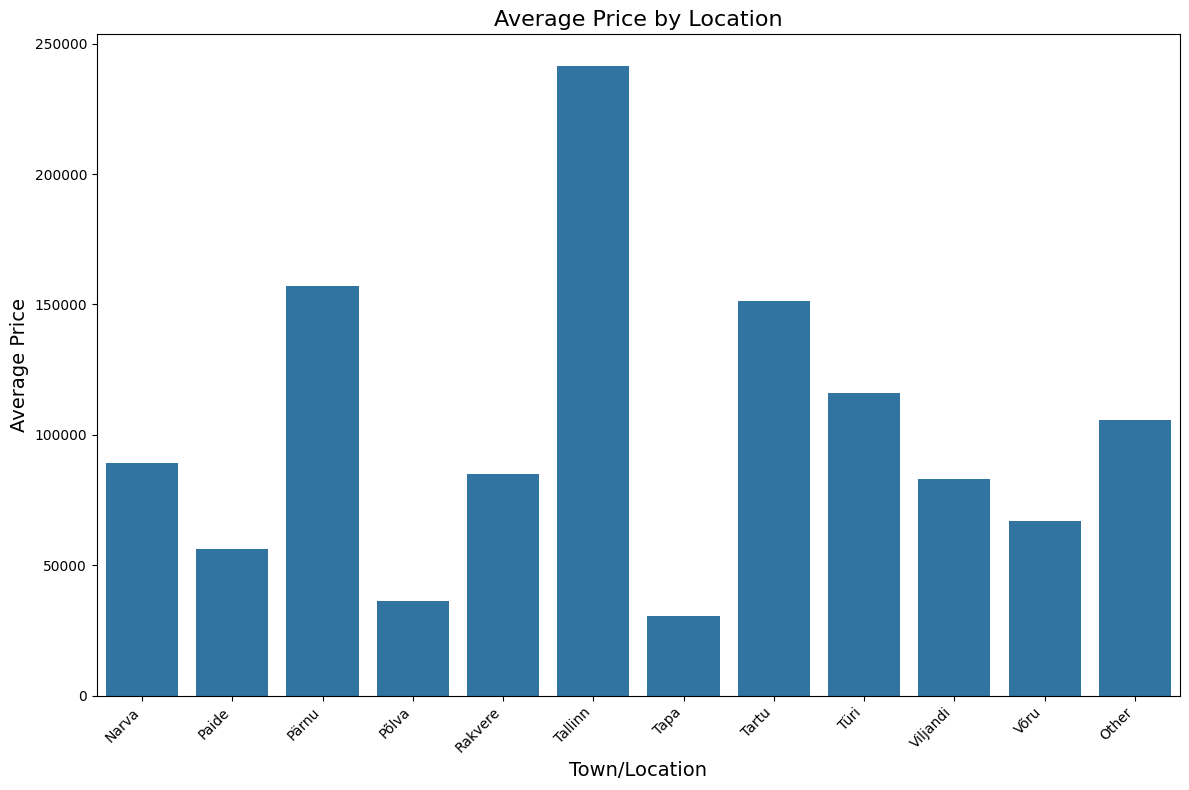

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame `sale_data` with the appropriate columns
town_columns = ['Town_Narva', 'Town_Paide', 'Town_Pärnu', 'Town_Põlva', 'Town_Rakvere',
                'Town_Tallinn', 'Town_Tapa', 'Town_Tartu', 'Town_Türi', 'Town_Viljandi',
                'Town_Võru', 'Town_Unknown']

# Mapping of the column names to more readable town names
town_mapping = {
    'Town_Narva': 'Narva',
    'Town_Paide': 'Paide',
    'Town_Pärnu': 'Pärnu',
    'Town_Põlva': 'Põlva',
    'Town_Rakvere': 'Rakvere',
    'Town_Tallinn': 'Tallinn',
    'Town_Tapa': 'Tapa',
    'Town_Tartu': 'Tartu',
    'Town_Türi': 'Türi',
    'Town_Viljandi': 'Viljandi',
    'Town_Võru': 'Võru',
    'Town_Unknown': 'Other'
}

# Calculate the average price for each location
average_prices_by_town = []
for town in town_columns:
    # Filter rows where the town column is 1 and calculate the mean price
    avg_price = sale_data[sale_data[town] == 1]['Price'].mean()
    average_prices_by_town.append(avg_price)

# Rename the towns based on the mapping
town_labels = [town_mapping[town] for town in town_columns]

# Creating a plot
plt.figure(figsize=(12, 8))
sns.barplot(x=town_labels, y=average_prices_by_town)

# Adding titles and labels
plt.title('Average Price by Location', fontsize=16)
plt.xlabel('Town/Location', fontsize=14)
plt.ylabel('Average Price', fontsize=14)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()


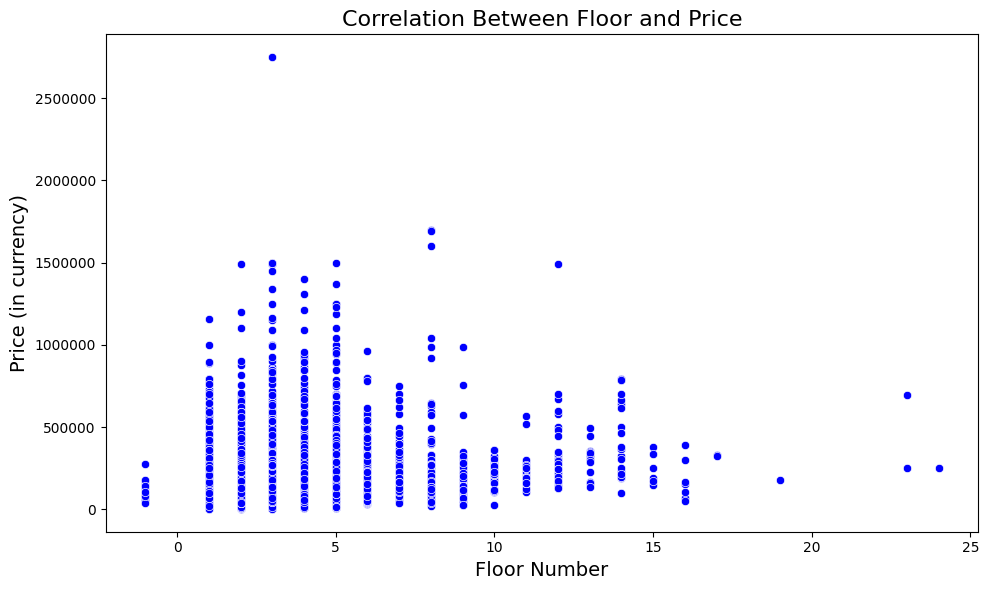

Most Expensive Apartment:
Price              2750000
Amount of Rooms        9.0
Surface Area         726.3
Type                     1
Floor                    3
Total Floors       5.04273
Town_Narva           False
Town_Paide           False
Town_Pärnu           False
Town_Põlva           False
Town_Rakvere         False
Town_Tallinn          True
Town_Tapa            False
Town_Tartu           False
Town_Türi            False
Town_Unknown         False
Town_Viljandi        False
Town_Võru            False
Name: 8505, dtype: object


In [231]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'Floor' column is treated as integers
sale_data['Floor'] = sale_data['Floor'].astype(int)

# Scatter plot to visualize correlation between 'Floor' and 'Price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sale_data['Floor'], y=sale_data['Price'], color='blue')

# Adding titles and labels
plt.title('Correlation Between Floor and Price', fontsize=16)
plt.xlabel('Floor Number', fontsize=14)
plt.ylabel('Price (in currency)', fontsize=14)

# Set y-axis to display prices in a readable format, if needed
plt.ticklabel_format(style='plain', axis='y')  # To avoid scientific notation (1e6 etc.)

# Display the plot
plt.tight_layout()
plt.show()
# Sort the DataFrame by the 'Price' column in descending order
most_expensive_apartment = sale_data.sort_values(by='Price', ascending=False).iloc[0]

# Display the most expensive apartment details
print("Most Expensive Apartment:")
print(most_expensive_apartment)


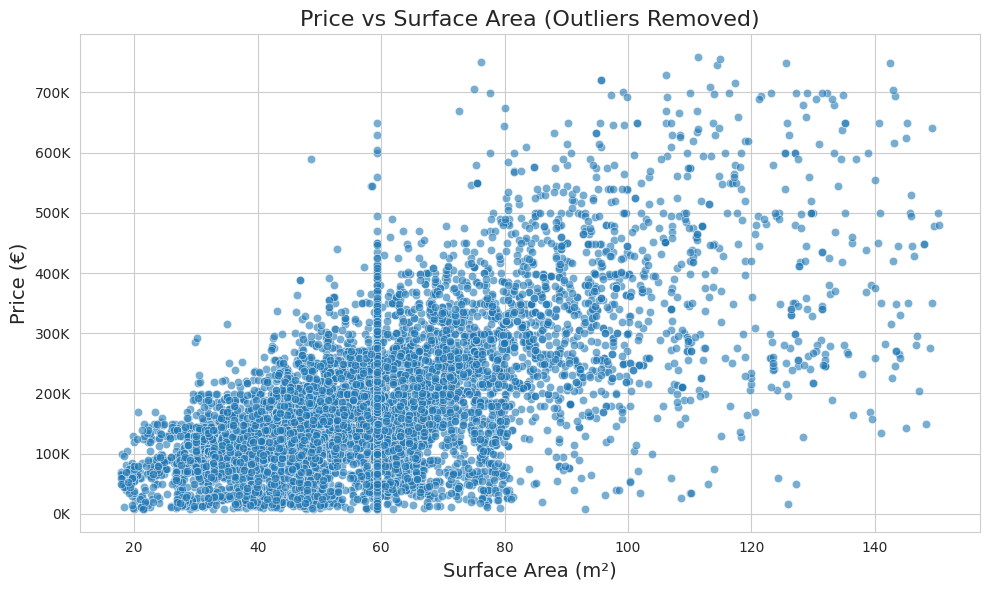

In [248]:
import numpy as np

# Define a threshold to filter outliers (e.g., based on the 1st and 99th percentiles)
lower_bound_price = sale_data['Price'].quantile(0.01)
upper_bound_price = sale_data['Price'].quantile(0.99)
lower_bound_area = sale_data['Surface Area'].quantile(0.01)
upper_bound_area = sale_data['Surface Area'].quantile(0.99)

# Filter the data to remove outliers
filtered_data = sale_data[
    (sale_data['Price'] >= lower_bound_price) &
    (sale_data['Price'] <= upper_bound_price) &
    (sale_data['Surface Area'] >= lower_bound_area) &
    (sale_data['Surface Area'] <= upper_bound_area)
]

# Create the scatter plot for the filtered data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=filtered_data['Surface Area'], y=filtered_data['Price'], alpha=0.6)

# Format the y-axis labels to show prices as K (e.g., 50K, 100K)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x / 1000)}K'))

# Adding titles and labels
plt.title('Price vs Surface Area (Outliers Removed)', fontsize=16)
plt.xlabel('Surface Area (m²)', fontsize=14)
plt.ylabel('Price (€)', fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()
